# Text Mining - Document Summary

History:

- 2017/9/7: 
    - 移除文章內的google廣告
    - 用逗號和問號斷句
    - 加入similar words
        - check read01_summary
    - 加入兩張圖(tf-idf keywords, similar words)
        - check keywordmap
- 2017/9/11:
    - 建立user dict
    - 用jieba抓tfidf key words
- 2017/9/12:
    - word2vec
    - pca, tsne for visualization
    - LDA
- 2017/9/13:
    - add tf in bar chart
    - bar cahrt for LDA
    - w2v k-means clustering 
    - stop word在jieba.cut沒有作用, 改成再斷詞時另外處理
        - check stpwrdlst
- 2017/9/15
    - 過濾非文章內容的sentence and word
        - check data_delete, data_clean
    - update userdict.txt:
        - 工業四點零
    - 加入英文stop words
    - 加入中文stop words:
        - 則是
        - 將要
        - 則要
    - 加入tf-idf scatter plot
    - 修正key word from jieba tfidf
        - 改成用已經過濾過的sentence (word_str)

  

Reference:
- 用scikit-learn学习LDA主题模型
    - http://www.cnblogs.com/pinard/p/6908150.html
    - http://blog.csdn.net/eastmount/article/details/50824215
    
- 中文文本挖掘预处理流程总结
    - http://www.cnblogs.com/pinard/p/6744056.html
    
- Mining English and Korean text with Python
    https://www.lucypark.kr/courses/2015-ba/text-mining.html
    
- NLTK (POS, chunk, Parser tree)    
    - http://aweiho2015.pixnet.net/blog/post/10269587-%5B%E8%AA%8D%E8%AD%98%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86%28text-mining%29%5D--%E5%A6%82%E4%BD%95%E8%99%95%E7%90%86%E4%B8%80%E5%8F%A5
    
- TF-IDF and TextRank
    - http://zhicongchen.github.io/2016/11/22/TF-IDF-and-TextRank/
    
- 中文斷詞：斷句不要悲劇 / Head first Chinese text segmentation    
    - https://speakerdeck.com/fukuball/head-first-chinese-text-segmentation

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

import jieba
import jieba.analyse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import re
import ast

import random
from flask import Flask, g, render_template, request
import logging
import html_template as ht
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import collections
import pickle
import itertools
from IPython.display import HTML

from sklearn import cluster, datasets, metrics


from collections import OrderedDict
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline

pd.set_option('display.max_columns', None)
punct = u'''\n +-％%:!),.:;?]}¢'"、。〉》」』】〕〗〞︰|︱︳丨﹐､﹒﹔﹕﹖﹗﹚﹜﹞！），．：；？｜｝︴︶︸︺︼︾﹀﹂﹄﹏､～￠々‖•·ˇˉ―′’”([{£¥'"‵〈《「『【〔〖（［｛￡￥〝︵︷︹︻︽︿﹁﹃﹙﹛﹝（｛“‘—_…~/#><'''
jieba.set_dictionary('dict.txt.big')
jieba.load_userdict('userdict.txt')


/Users/jayhsu/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
Building prefix dict from /Users/jayhsu/work/github/textmining/dict.txt.big ...
Loading model from cache /var/folders/yf/hq7ghg4j3ksb8k34wyh8vk2m0000gn/T/jieba.ub36e993abda9bbf53d1f5b38e3ae9b44.cache
Loading model cost 2.990 seconds.
Prefix dict has been built succesfully.


In [3]:
#中文字型
fp = matplotlib.font_manager.FontProperties(fname = 'font/NotoSansCJKtc-Regular.otf')
matplotlib.font_manager.fontManager.ttffiles.append(fp.get_file())
font_entry = matplotlib.font_manager.FontEntry(fp.get_file(), name=fp.get_name(),
                                               style=fp.get_style(), variant=fp.get_variant(),
                                              weight=fp.get_weight(), stretch=fp.get_stretch(), size=fp.get_size())

matplotlib.font_manager.fontManager.ttflist.append(font_entry)
plt.rcParams['font.family'] = fp.get_name()

stpwrdpath = "model/stop_words_new.txt"
stpwrd_dic = open(stpwrdpath, 'r')
stpwrd_content = stpwrd_dic.read()
stpwrdlst = stpwrd_content.splitlines()
stpwrd_dic.close()



In [4]:
def sort2list(list1, list2):
    list1, list2 = (list(t) for t in zip(*sorted(zip(list1, list2),reverse=True)))
    return list1, list2

def keywords(row, voc_dic, kwtopn=3, withWeight=False):
    keywork_list=[]
    keyworkWweight_list=[]
    tfidf_vec = row['tfidf_vector']
    topn = list(set(tfidf_vec))
    topn.sort(reverse=True)
    for top in topn[:kwtopn]:
        if top==0:
            continue
        winner = np.argwhere([x ==top for x in tfidf_vec ])
        idxlist =winner.flatten().tolist() 
        for i in idxlist:
            keywork_list.append(voc_dic.get(i))
            keyworkWweight_list.append((voc_dic.get(i), top)  )
        if len(keywork_list)>=kwtopn:
            break
    if withWeight:
        return tuple(keyworkWweight_list) 
    else:
        return tuple(keywork_list) 
    
def docsummary(row):
    doc_list = row['sentences']
    keywords = row['keywords']
    if keywords:
        keysentencelist=[]
        for doc in doc_list:
            doc = doc.lower()
            for kw in keywords:
                if kw in doc and doc not in keysentencelist:
                    keysentencelist.append(doc)
                    
        #summary_str = ','.join(keysentencelist)
        summary_str=''
        strlen = 0
        for sen in keysentencelist[:10]:
            if strlen>50:
                strlen = len(sen)
                summary_str=summary_str+',\n'+sen
            else:
                strlen = strlen + len(sen)
                summary_str=summary_str+','+sen
    else:
        summary_str='NA'
        
    return summary_str


In [5]:
data_cleanregex = ['\[SS_\w+\]','\(adsbygoogle.+\)\;']
data_deleteregex_ = [r'.*\.srt$']

def data_clean(dirty_str):
    tmp_str = dirty_str
    for pat in data_cleanregex:
        tmp_str = re.sub(pat, '', tmp_str)
    return tmp_str

data_deleteregex = list(map(lambda x: re.compile(x), data_deleteregex_))
def data_delete(dirty_str):
    tmp_str = dirty_str
    for pattern in data_deleteregex:
        #pattern = re.compile(pat)  
        match1 = pattern.match(dirty_str)
        if match1:
            return True
    return False        
    
    
def read01_summary(folder, topic, kw_topn=3):
    files = os.listdir('{f}/{w}'.format(f=folder, w=topic))
    docs=[]
    fileName=[]
    
    for fidx, fname in enumerate(files):
        if fname.startswith('.') or fname.endswith('.flag') :
            continue

        file = open('{fd}/{w}/{f}'.format(fd=folder, w=topic, f=fname), 'r') 
        doc =[] 
        for line in file.readlines():                          
            line = line.strip()
            if not len(line):                               
                continue
            if data_delete(line):
                continue
                
            line = data_clean(line)
            
            doc.append(line) 
        if len(doc)==0:
            continue
        docs.append('\n'.join(doc))
        fileName.append(str(fidx)+'_'+fname)

    dl_df = pd.DataFrame({'fname':fileName, 'doc':docs})
    dl_df.sort_values(by='fname')
    dl_df['sentences']=dl_df['doc'].map(lambda x: re.split("[\n\r，。？]+", x))
    #dl_df['doc']=dl_df['sentences'].map(lambda x: '\n'.join(x))
    dl_df['words'] =   dl_df['doc'].map(lambda x: [_.lower() for _ in jieba.cut(x) if _ not in punct and _ not in stpwrdlst]) 
    dl_df['words_str'] = dl_df['words'].map(lambda x: ' '.join(x))
    cv = CountVectorizer()
    vecs1 = cv.fit_transform(dl_df['words_str']).toarray()
    
    doclen= list(dl_df['words'].map(lambda x:len(x)))
    tf_vec = [(a/b).tolist() for a,b in zip(vecs1.tolist(), doclen)]
    dl_df['tf_vector'] = tf_vec
    fea = cv.get_feature_names()
    key = range(len(fea))
    voc_dic = dict(zip(key, fea))
    vockey_dic = dict(zip(fea, key))
    tfidf = TfidfTransformer()
    vecs2 = tfidf.fit_transform(vecs1).toarray()
    dl_df['tfidf_vector'] = [_ for _ in vecs2]

    dl_df['keywords_w'] = dl_df.apply(keywords, axis=1, args=(voc_dic,kw_topn,True))
    dl_df['keywords'] = dl_df['keywords_w'].map(lambda x:list(list(zip(*x))[0]))
    
    #dl_df['summary'] = dl_df.apply(docsummary, axis=1)
    
    dl_w2v_model = Word2Vec(dl_df['words'], min_count=1, size=100,iter=50)
    
    all_keywords = sum(list(dl_df['keywords']),[])
    vec = np.array([dl_w2v_model[w] for w in all_keywords if w in dl_w2v_model ])
    dl_pca = PCA(20)
    dl_pca.fit(vec)
    
    return dl_df, voc_dic,vockey_dic, dl_w2v_model, dl_pca




In [128]:
def loaddocs(folder, topic):
    files = os.listdir('{f}/{w}'.format(f=folder, w=topic))
    docs=[]
    fileName=[]
    
    for fidx, fname in enumerate(files):
        if fname.startswith('.') or fname.endswith('.flag') :
            continue

        file = open('{fd}/{w}/{f}'.format(fd=folder, w=topic, f=fname), 'r') 
        doc =[] 
        for line in file.readlines():                          
            line = line.strip()
            if not len(line):                               
                continue
            if data_delete(line):
                continue
                
            line = data_clean(line)
            
            doc.append(line) 
        if len(doc)==0:
            continue
        docs.append('\n'.join(doc))
        fileName.append(str(fidx)+'_'+fname)
    dl_df = pd.DataFrame({'fname':fileName, 'doc':docs})
    return dl_df
    
def tokenize(dl_df):
    dl_df.sort_values(by='fname')
    dl_df['sentences']=dl_df['doc'].map(lambda x: re.split("[\n\r，。？]+", x))
    dl_df['words'] = dl_df['doc'].map(lambda x: [_.lower() for _ in jieba.cut(x) if _ not in punct and _ not in stpwrdlst]) 
    dl_df['words_str'] = dl_df['words'].map(lambda x: ' '.join(x))
    return dl_df

def keywords_tfidf(dl_df, topn):
    dictionary = gensim.corpora.Dictionary(dl_df['words'])  
    inverse_dict  = dictionary.token2id
    corpus = [dictionary.doc2bow(text) for text in dl_df['words']] 
    tfidf = gensim.models.TfidfModel(corpus)  
    corpus_tfidf = tfidf[corpus]  
    dl_df['tfidf_vector'] = [_ for _ in corpus_tfidf]
    
    dl_df['tfidf_vector'] = dl_df['tfidf_vector'].map(lambda x: sorted(x, key=lambda tup: tup[1],reverse=True))
    dl_df['tfidf_vector'] = dl_df['tfidf_vector'].map(lambda lst: list(map(lambda x:(dictionary[x[0]],x[1]),lst)))
    dl_df['keywords_w'] = dl_df['tfidf_vector'].map(lambda x: x[:topn] )
    dl_df['keywords'] = dl_df['keywords_w'].map(lambda x:list(list(zip(*x))[0]))
    
    return dl_df, dictionary, inverse_dict, tfidf

def get_w2vmodel():
    dl_w2v_model = Word2Vec(dl_df['words'], min_count=1, size=100,iter=50)
    all_keywords = sum(list(dl_df['keywords']),[])
    vec = np.array([dl_w2v_model[w] for w in all_keywords if w in dl_w2v_model ])
    dl_pca = PCA(20)
    dl_pca.fit(vec)
    return dl_w2v_model, dl_pca, tfidf


***
***

In [9]:
folder_doc = 'text/techdoc'  
topic = '深度學習'#'深度學習' # 'MARK' #資料夾

** 一篇文章分析 ** 

In [99]:
dictionary = gensim.corpora.Dictionary(dl_df['words'])  
inverse_dict  = dictionary.token2id
corpus = [dictionary.doc2bow(text) for text in dl_df['words']] 
tfidf = gensim.models.TfidfModel(corpus)  
corpus_tfidf = tfidf[corpus]  
dl_df['tfidf_vector'] = [_ for _ in corpus_tfidf]

In [133]:
dl_df, dl_voc_dic, dl_vockey_dic, dl_w2v_model, dl_pca = read01_summary(folder = folder_doc, topic=topic, kw_topn=50)

dl_df2 = loaddocs(folder = folder_doc, topic=topic)
dl_df2= tokenize(dl_df2)
dl_df2, dl_voc_dic2, dl_vockey_dic2, tfidfM= keywords_tfidf(dl_df, 100)


** 1. 檢查斷詞效果 **

In [135]:
docid=13

In [8]:
#dl_df['doc'][docid]

In [136]:
keywords_predefined = ['nvidia', 'geforce', 'gtx', 'titan', '深度學習','訓練系統','devbox']
#keywords_predefined = '好不好','把它','重點是','我們要','你要','你去','策略','目的','function','負責','風險','注意','生意','生意模式','marketing','經營','價值','目標','target','我要','給我','我們','可以','你現在','我就可以','營收','計畫','投資','錢','賣錢','賺錢','有錢','數字','百','億','找一個','那個','所以','所以呢','經管','政府','smart','smart office','infocus','夏普','sharp','專注','核心競爭力','董事長','terry','CEO','老大','富士康','AI','Deep learning','IoT','工業4.0','要不要','有沒有','可不可以','媽的','管你','禮拜幾','要要','然後','KPI','某些人名','schedule','追','大概','結論','大概就是這樣'
keywords_predefined = list(map(lambda x:x.upper(), keywords_predefined))


In [139]:
print('斷詞:')
print(', '.join(list(dl_df['words'][docid])))

missing_words= list(filter(lambda x: x.upper() not in list(map(lambda x: x.upper(), dl_df['words'][docid])) , keywords_predefined))
print('\n\n\n沒斷好的word:{ms}\n\n'.format(ms=missing_words))

斷詞:
it168, 資訊, 解決, 當今世界, 尖端, 技術, 挑戰, nvidia, 剛剛, 推出, 全新, 硬體, 軟體, 前所未有, 提高, 深度學習, 研究, 速度, 易用性, 功用, 人工智慧, 領域, 快速, 成長, 深度學習, 技術, 一項, 創新, 計算, 引擎, 從先, 進, 醫藥, 研究, 全自動, 駕駛, 汽車, 多元, 領域, nvidia, 聯合, 創始人, 總裁兼, 執行長, 黃仁勛, gpu, 技術, 大會, 開幕, 主題, 演講, 活動, 在座, 四千名, 與會, 嘉賓, 展示, 三項, 推動, 深度學習, 新技術, nvidia, geforce, gtx, titan, x, 訓練, 深度神經網絡, 開發, 強大, 處理器, digits, 深度學習, gpu, 訓練, 系統, 數據科學家, 研究人員, 利用, 這套, 軟體, 便捷, 開發, 高品質, 深度神經網絡, digits, devbox, 全球, 最快, 桌邊型, 深度學習, 工具, 專為, 相關, 打造, 採用, titan, x, gpu, 搭配, 直觀, 易用, digits, 訓練, 系統, geforce, gtx, titan, x, 另一面, titanx, nvidia, 全新, 推出, 旗艦級, 遊戲, 顯卡, 特別, 適合, 深度學習, 舊金山, 舉辦, 遊戲, 開發者, 大會, 先睹為快, titan, x, 身影, 電影, 霍比特, 里, 史, 矛戈, 巨龍, 藍本, 播放, 一段, 名為, 暗影, 神偷, 精彩, 虛擬現實, 體驗, titanx, 上能, 4k, 超, 高畫質, 呈現, 最新, aaa, 遊戲, 大作, 瑰麗, 畫面, 開啟, fxaa, 高, 設定值, 情況, 每秒, 40, 幀, 40fps, 運行, 中土, 世界, 暗影, 魔多, middle, earth, shadow, mordor, 遊戲, 九月, 發行, geforce, gtx, 980, 上則, 30fps, 運行, 採用, nvidia, maxwell, gpu, 架構, titan, x, 3072, 核心, 單精度, 峰值, 性能, teraflops, 板載, 12gb, 顯存, 性能, 性能功耗比, 皆, 前代, 產品, 兩倍, 強大, 能力

** 2. extract key words **

 - TF-IDF (IDF: 100篇read01的深度學習文章)

In [140]:
print('Domain Keywords (user idf): ')
#print(', '.join(list(v['keywords'][docid])))
kw_x, kw_y = zip(*(dl_df['keywords_w'][docid]))
kw_y = list(map(lambda x: float('%.3f'% x),kw_y))
tfvec=dl_df['tf_vector'][docid]
tfidf_df = pd.DataFrame({'keyword':kw_x, 'tfidf':kw_y})
tfidf_df['tf']=tfidf_df['keyword'].map(lambda x: tfvec[dl_vockey_dic[x]])
tfidf_df['idf'] = tfidf_df['tfidf']/tfidf_df['tf']
display(tfidf_df[:10])

print('Predefined Keywords')
tfidf_df['tmp'] = tfidf_df['keyword'].map(lambda x: x.upper())
missing_words= list(filter(lambda x: x.upper() not in list(tfidf_df['tmp']) , keywords_predefined))
predefined_df = tfidf_df.loc[tfidf_df['tmp'].isin(keywords_predefined)].drop('tmp', axis=1)
display(predefined_df)

print('missing words:',missing_words)
plt.figure(figsize=(12,6))
barlist = plt.bar(range(len(kw_y)), kw_y, label='tfidf')
plt.bar(range(len(kw_y)), tfidf_df['tf'], label='tf')
plt.xticks(range(len(kw_x)), kw_x,rotation=60, fontsize=12)
plt.legend()
plt.title('tfidf Keywords')

for idx, kw in enumerate(kw_x):
    if kw.upper() in keywords_predefined:
        barlist[idx].set_color('r')
plt.show()

        
fig = plt.figure(figsize=(11,11))
plt.scatter(tfidf_df['tf'], tfidf_df['idf'], label='tfidf keywords', marker='.')
plt.scatter(predefined_df['tf'], predefined_df['idf'], label='domain keywords', marker='*')

for i, label in enumerate(kw_x):
    x = tfidf_df['tf'][i]
    y = tfidf_df['idf'][i]
    if label.upper() in keywords_predefined:
        color = 'red'
    else:
        color='black'
    plt.annotate(label.upper(),
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=13,
                 color=color,
                 ha='right',
                 va='bottom')

plt.xlabel('TF')
plt.ylabel('IDF')
plt.title('TF-IDF Scatter')
plt.legend()
plt.show()

Domain Keywords (user idf): 


KeyError: 'x'

Domain Keywords (user idf--): 


,keyword,tfidf,idf,tf
0,digits,0.394,3.198780,0.123172
1,titan,0.273,3.198780,0.085345
2,devbox,0.265,4.658211,0.056889
3,nvidia,0.167,2.198780,0.075951
4,geforce,0.164,4.336283,0.037820
5,gtx,0.154,4.073249,0.037808
6,x,0.154,1.800230,0.085545
7,深度神經網絡,0.127,1.488286,0.085333
8,titanx,0.126,6.658211,0.018924
9,暗影,0.126,6.658211,0.018924


Predefined Keywords


,keyword,tfidf,idf,tf
1,titan,0.273,3.198780,0.085345
2,devbox,0.265,4.658211,0.056889
3,nvidia,0.167,2.198780,0.075951
4,geforce,0.164,4.336283,0.037820
5,gtx,0.154,4.073249,0.037808


missing words: ['深度學習', '訓練系統']


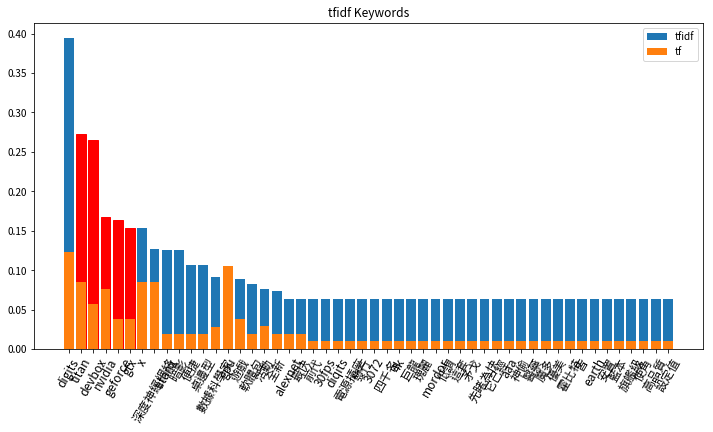

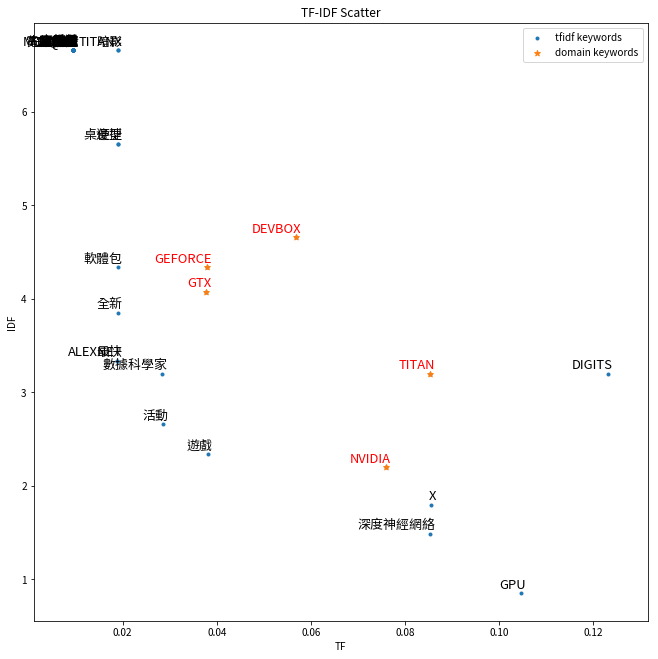

In [516]:
print('Domain Keywords (user idf--): ')
#print(', '.join(list(v['keywords'][docid])))
kw_x, kw_y = zip(*(dl_df2['keywords_w'][docid]))
kw_y = list(map(lambda x: float('%.3f'% x),kw_y))
tfidf_df = pd.DataFrame({'keyword':kw_x, 'tfidf':kw_y})
tfidf_df['idf']=tfidf_df['keyword'].map(lambda x: tfidfM.idfs[dl_vockey_dic2[x]])
tfidf_df['tf'] = tfidf_df['tfidf']/tfidf_df['idf']

display(tfidf_df[:10])

print('Predefined Keywords')
tfidf_df['tmp'] = tfidf_df['keyword'].map(lambda x: x.upper())
missing_words= list(filter(lambda x: x.upper() not in list(tfidf_df['tmp']) , keywords_predefined))
predefined_df = tfidf_df.loc[tfidf_df['tmp'].isin(keywords_predefined)].drop('tmp', axis=1)
display(predefined_df)

print('missing words:',missing_words)
plt.figure(figsize=(12,6))
barlist = plt.bar(range(len(kw_y)), kw_y, label='tfidf')
plt.bar(range(len(kw_y)), tfidf_df['tf'], label='tf')
plt.xticks(range(len(kw_x)), kw_x,rotation=60, fontsize=12)
plt.legend()
plt.title('tfidf Keywords')

for idx, kw in enumerate(kw_x):
    if kw.upper() in keywords_predefined:
        barlist[idx].set_color('r')
plt.show()

        
fig = plt.figure(figsize=(11,11))
plt.scatter(tfidf_df['tf'], tfidf_df['idf'], label='tfidf keywords', marker='.')
plt.scatter(predefined_df['tf'], predefined_df['idf'], label='domain keywords', marker='*')

for i, label in enumerate(kw_x):
    x = tfidf_df['tf'][i]
    y = tfidf_df['idf'][i]
    if label.upper() in keywords_predefined:
        color = 'red'
    else:
        color='black'
    plt.annotate(label.upper(),
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=13,
                 color=color,
                 ha='right',
                 va='bottom')

plt.xlabel('TF')
plt.ylabel('IDF')
plt.title('TF-IDF Scatter')
plt.legend()
plt.show()

 - TF-IDF (IDF: jieba內建語料庫)

Domain Keywords (jieba idf): 


,keyword,tfidf,tf,idf
0,深度學習,0.403,0.031315,12.869133
1,訓練,0.349,0.027140,12.859308
2,digits,0.349,0.027140,12.859308
3,gpu,0.296,0.022965,12.889455
4,titan,0.296,0.018789,15.753778
5,深度神經網絡,0.242,0.018789,12.879778
6,系統,0.215,0.016701,12.873125
7,nvidia,0.215,0.016701,12.873125
8,devbox,0.161,0.012526,12.853167
9,用戶,0.134,0.010438,12.837200


Predefined Keywords


,keyword,tfidf,tf,idf
0,深度學習,0.403,0.031315,12.869133
4,titan,0.296,0.018789,15.753778
7,nvidia,0.215,0.016701,12.873125
8,devbox,0.161,0.012526,12.853167
11,gtx,0.107,0.008351,12.813250
13,geforce,0.107,0.008351,12.813250


missing words: ['訓練系統']


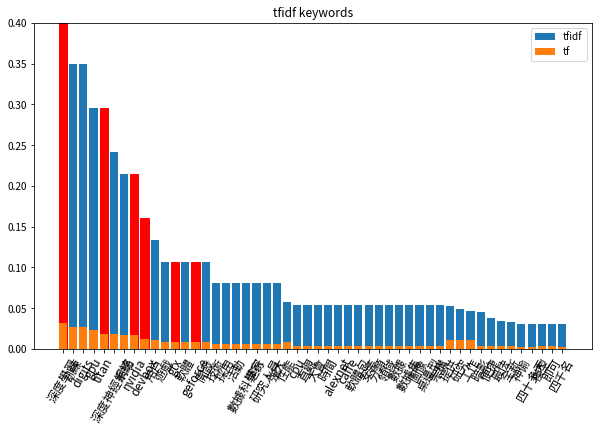

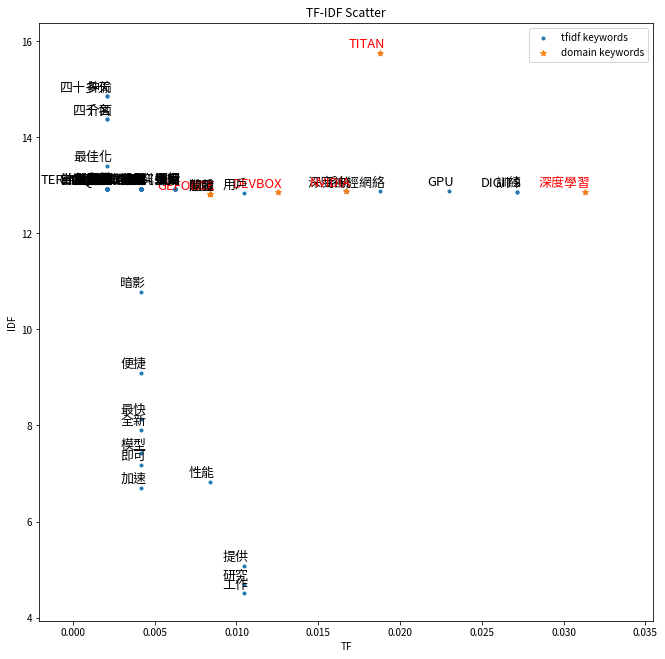

In [515]:
print('Domain Keywords (jieba idf): ')
kw_x, kw_y = zip(*jieba.analyse.tfidf(dl_df['words_str'][docid],topK=100, withWeight=True))
kw_y = list(map(lambda x: float('%.3f'% x),kw_y))
tfvec=dl_df['tf_vector'][docid]
tfidf_df = pd.DataFrame({'keyword':kw_x, 'tfidf':kw_y})
tfidf_df['tf']=tfidf_df['keyword'].map(lambda x: tfvec[dl_vockey_dic[x.lower()]])
tfidf_df['idf'] = tfidf_df['tfidf']/tfidf_df['tf']
display(tfidf_df[:10])

print('Predefined Keywords')
tfidf_df['tmp'] = tfidf_df['keyword'].map(lambda x: x.upper())
missing_words= list(filter(lambda x: x.upper() not in list(tfidf_df['tmp']) , keywords_predefined))
predefined_df = tfidf_df.loc[tfidf_df['tmp'].isin(keywords_predefined)].drop('tmp', axis=1)
display(predefined_df)
print('missing words:',missing_words)

disp_qty=50
plt.figure(figsize=(10,6))
xtmp=range(len(kw_y[:disp_qty]))
barlist = plt.bar(xtmp, kw_y[:disp_qty], label='tfidf')
plt.bar(xtmp, tfidf_df['tf'][:disp_qty], label='tf')
plt.xticks(xtmp, kw_x[:disp_qty],rotation=60, fontsize=12)
plt.legend()
plt.title('tfidf keywords')
plt.ylim(0,0.4)


for idx, kw in enumerate(kw_x[:disp_qty]):
    if kw.upper() in keywords_predefined:
        barlist[idx].set_color('r')

plt.show()

        
fig = plt.figure(figsize=(11,11))
plt.scatter(tfidf_df['tf'], tfidf_df['idf'], label='tfidf keywords', marker='.')
plt.scatter(predefined_df['tf'], predefined_df['idf'], label='domain keywords', marker='*')

for i, label in enumerate(kw_x):
    x = tfidf_df['tf'][i]
    y = tfidf_df['idf'][i]
    if label.upper() in keywords_predefined:
        color = 'red'
    else:
        color='black'
    plt.annotate(label.upper(),
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=13,
                 color=color,
                 ha='right',
                 va='bottom')

plt.xlabel('TF')
plt.ylabel('IDF')
plt.title('TF-IDF Scatter')
plt.legend()
plt.show()


**3. Clustering **

  - word2vec word similarity 

similar words (tfidf keywords)


,keyword,tfidf,tf,idf,similar words
0,深度學習,0.403,0.031315,12.869133,"[(成熟, 0.554), (現有, 0.523), (特指, 0.504), (模式識別, 0.491), (發展趨勢, 0.481), (探索, 0.481), (之中, 0.477), (學習, 0.468), (這類, 0.467), (突破, 0.465)]"
1,訓練,0.349,0.027140,12.859308,"[(預, 0.643), (結構複雜, 0.624), (各層, 0.583), (初始化, 0.58), (異步, 0.575), (微調, 0.57), (第一步, 0.564), (tune, 0.559), (交換, 0.547), (擬合, 0.546)]"
2,digits,0.349,0.027140,12.859308,"[(devbox, 0.8), (便捷, 0.785), (完整版, 0.753), (桌邊型, 0.747), (devserver, 0.74), (圖形系統, 0.726), (搭配, 0.703), (多合一, 0.697), (自帶, 0.679), (geforce, 0.668)]"
3,gpu,0.296,0.022965,12.889455,"[(cpu, 0.67), (集群, 0.669), (處理器, 0.634), (得花, 0.631), (卡, 0.609), (單卡, 0.605), (nvlink, 0.596), (infiniband, 0.596), (高速, 0.595), (四十多天, 0.591)]"
4,titan,0.296,0.018789,15.753778,"[(gtx, 0.848), (devbox, 0.844), (geforce, 0.823), (maxwell, 0.819), (搭配, 0.804), (970, 0.795), (1080, 0.787), (x, 0.781), (賣, 0.78), (旗艦, 0.762)]"
5,深度神經網絡,0.242,0.018789,12.879778,"[(預, 0.567), (極慢, 0.567), (深層, 0.543), (訓練方法, 0.526), (dbns, 0.516), (挑戰, 0.51), (三四十, 0.51), (機制, 0.505), (99, 0.505), (mariana, 0.503)]"
6,系統,0.215,0.016701,12.873125,"[(地下, 0.511), (下篇, 0.479), (更能, 0.462), (量身, 0.457), (坑洞, 0.453), (環境, 0.453), (它還, 0.452), (首套, 0.447), (靈長類, 0.44), (端到, 0.438)]"
7,nvidia,0.215,0.016701,12.873125,"[(廠商, 0.805), (搭配, 0.798), (maxwell, 0.793), (一貫, 0.786), (k40, 0.781), (nvlink, 0.778), (pandey, 0.762), (cudnn, 0.762), (桌邊型, 0.759), (tesla, 0.756)]"
8,devbox,0.161,0.012526,12.853167,"[(titan, 0.844), (專為, 0.8), (digits, 0.8), (geforce, 0.798), (gtx, 0.781), (maxwell, 0.781), (tesla, 0.768), (搭配, 0.762), (970, 0.761), (便宜, 0.754)]"
9,用戶,0.134,0.010438,12.837200,"[(介面, 0.71), (體驗, 0.66), (上傳, 0.649), (偏好, 0.633), (門電路, 0.629), (友好, 0.614), (解釋器, 0.596), (數字電路, 0.592), (可作, 0.59), (事, 0.582)]"


similar words (predefined keywords)


,keyword,tfidf,tf,idf,similar words
0,深度學習,0.403,0.031315,12.869133,"[(成熟, 0.554), (現有, 0.523), (特指, 0.504), (模式識別, 0.491), (發展趨勢, 0.481), (探索, 0.481), (之中, 0.477), (學習, 0.468), (這類, 0.467), (突破, 0.465)]"
4,titan,0.296,0.018789,15.753778,"[(gtx, 0.848), (devbox, 0.844), (geforce, 0.823), (maxwell, 0.819), (搭配, 0.804), (970, 0.795), (1080, 0.787), (x, 0.781), (賣, 0.78), (旗艦, 0.762)]"
7,nvidia,0.215,0.016701,12.873125,"[(廠商, 0.805), (搭配, 0.798), (maxwell, 0.793), (一貫, 0.786), (k40, 0.781), (nvlink, 0.778), (pandey, 0.762), (cudnn, 0.762), (桌邊型, 0.759), (tesla, 0.756)]"
8,devbox,0.161,0.012526,12.853167,"[(titan, 0.844), (專為, 0.8), (digits, 0.8), (geforce, 0.798), (gtx, 0.781), (maxwell, 0.781), (tesla, 0.768), (搭配, 0.762), (970, 0.761), (便宜, 0.754)]"
11,gtx,0.107,0.008351,12.813250,"[(1080, 0.954), (970, 0.935), (960, 0.931), (1070, 0.92), (了並, 0.918), (ebay, 0.895), (980, 0.895), (賣, 0.895), (過得去, 0.87), (titan, 0.848)]"
13,geforce,0.107,0.008351,12.813250,"[(tesla, 0.829), (titan, 0.823), (g2, 0.812), (960, 0.811), (maxwell, 0.804), (gtx, 0.801), (另一面, 0.799), (devbox, 0.798), (搭配, 0.789), (4gb, 0.788)]"


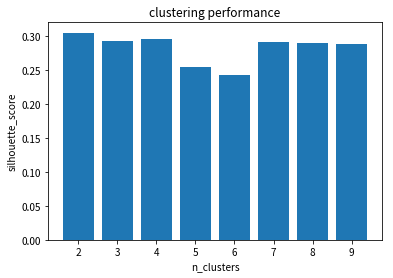

[0.30543551, 0.2926068, 0.29556006, 0.25530526, 0.24329688, 0.29228923, 0.29057229, 0.28855455]
Clustering by k-means: 


,0,1,2,3,4
0,深度學習,devbox,digits,分類,時間
1,訓練,用戶,gpu,NaN,NaN
2,深度神經網絡,遊戲,titan,NaN,NaN
3,系統,軟體,nvidia,NaN,NaN
4,技術,geforce,gtx,NaN,NaN
5,採用,開發,運行,NaN,NaN
6,性能,活動,cpu,NaN,NaN
7,領域,數據科學家,安裝,NaN,NaN
8,數據,研究人員,加速,NaN,NaN
9,數據集,強大,處理器,NaN,NaN


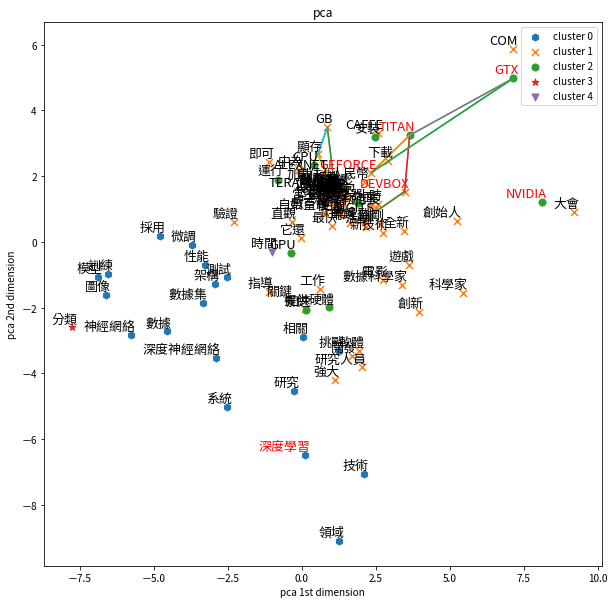

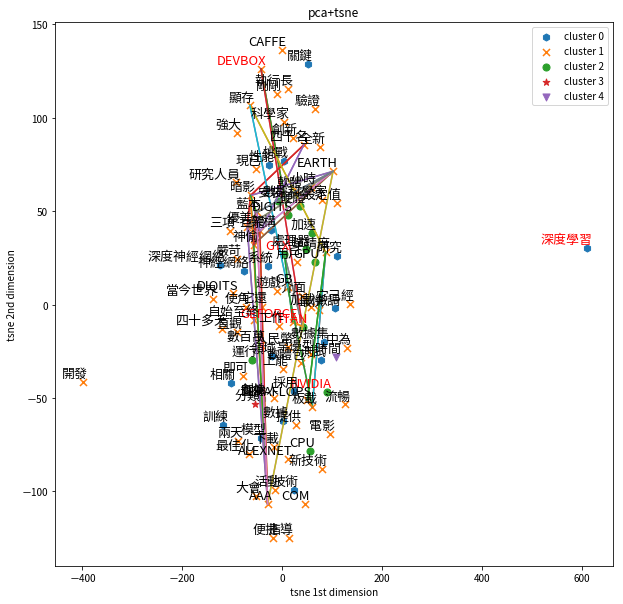

In [259]:
clusters=5

kw_x = jieba.analyse.tfidf(dl_df['words_str'][docid],topK=100, withWeight=False)
vec_kw = [list(dl_w2v_model[w.lower()]) for w in kw_x]
#vec_kw = np.array ([list(dl_w2v_model[w.lower()]) for w in kw_x])


w2vkmeans = KMeans(n_clusters=clusters, n_init=20, n_jobs=-1).fit(np.array(vec_kw))
silhouette_avg_ = metrics.silhouette_score(np.array(vec_kw), w2vkmeans.labels_,metric='euclidean')
#['cityblock', 'cosine', 'euclidean', 'l1', 'l2','manhattan']
group=w2vkmeans.predict(vec_kw)
group_dic ={} 
for i in range(clusters):
    idx = np.argwhere([x ==i for x in group ])
    group_dic[i]=np.array(kw_x)[idx.flatten().tolist()].tolist()


print('similar words (tfidf keywords)')
kw_x, kw_y = zip(*jieba.analyse.tfidf(dl_df['words_str'][docid],topK=100, withWeight=True))
kw_y = list(map(lambda x: float('%.3f'% x),kw_y))
tfvec=dl_df['tf_vector'][docid]
tfidf_df = pd.DataFrame({'keyword':kw_x, 'tfidf':kw_y})
tfidf_df['tf']=tfidf_df['keyword'].map(lambda x: tfvec[dl_vockey_dic[x.lower()]])
tfidf_df['idf'] = tfidf_df['tfidf']/tfidf_df['tf']
tfidf_df['similar words']=tfidf_df['keyword'].map(lambda kw: list(map(lambda x: (x[0], float('%.3f'% x[1])), dl_w2v_model.most_similar(kw,topn=10))))
display(tfidf_df[:10])


tfidf_df['tmp'] = tfidf_df['keyword'].map(lambda x: x.upper())
predefined_df = tfidf_df.loc[tfidf_df['tmp'].isin(keywords_predefined)].drop('tmp', axis=1)
predefined_df['similar words']=predefined_df['keyword'].map(lambda kw: list(map(lambda x: (x[0], float('%.3f'% x[1])), dl_w2v_model.most_similar(kw,topn=10))))
print('similar words (predefined keywords)')
display(predefined_df)


silhouette_avgs = []
ks = range(2, 10)
for k in ks:
    kmeans_fit = KMeans(n_clusters = k).fit(np.array(vec_kw))
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(np.array(vec_kw), cluster_labels)
    silhouette_avgs.append(silhouette_avg)
plt.bar(ks, silhouette_avgs)
plt.title('clustering performance')
plt.ylabel('silhouette_score')
plt.xlabel('n_clusters')
plt.show()
print(silhouette_avgs)

print('Clustering by k-means: ')
display(pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in group_dic.items() ]))[:15])


vec_pca = dl_pca.transform(vec_kw)
tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=10000,)
vec_tsne = tsne.fit_transform(vec_pca)

plt.clf()
fig = plt.figure(figsize=(10,10))
marker = itertools.cycle(['h', 'x', 'o', '*','v','d','h']) 
for i in range(clusters):
    idx = np.argwhere([x ==i for x in group ])
    data = vec_pca[idx.flatten().tolist()]
    plt.scatter(data[:, 0], data[:, 1], s= 50, label='cluster {g}'.format(g=i),marker=next(marker))
plt.legend()
plt.xlabel('pca 1st dimension')
plt.ylabel('pca 2nd dimension')

for i, label in enumerate(kw_x):
    x, y = vec_pca[i][:2]
    if label.upper() in keywords_predefined:
        color = 'red'
    else:
        color='black'
    plt.annotate(label.upper(),
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=13,
                 color=color,
                 ha='right',
                 va='bottom')

for i1, label_1 in enumerate(kw_x):
    x1, y1 = vec_pca[i1][:2]
    for i2, label_2 in enumerate(kw_x):
        x2, y2 = vec_pca[i2][:2]
        similarity = dl_w2v_model.similarity(label_1.lower(), label_2.lower())
        if(similarity>0.8):
            plt.plot([x1,x2], [y1,y2])
plt.title('pca')
    
    
fig = plt.figure(figsize=(10,10))
marker = itertools.cycle(['h', 'x', 'o', '*','v','d','.']) 
for i in range(clusters):
    idx = np.argwhere([x ==i for x in group ])
    data = vec_tsne[idx.flatten().tolist()]
    plt.scatter(data[:, 0], data[:, 1], s= 50, label='cluster {g}'.format(g=i),marker=next(marker))
plt.legend()
plt.xlabel('tsne 1st dimension')
plt.ylabel('tsne 2nd dimension')


for i, label in enumerate(kw_x):
    x, y = vec_tsne[i][:2]
    if label.upper() in keywords_predefined:
        color = 'red'
    else:
        color='black'
    plt.annotate(label.upper(),
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=13,
                 color=color,
                 ha='right',
                 va='bottom')

for i1, label_1 in enumerate(kw_x):
    x1, y1 = vec_tsne[i1][:2]
    for i2, label_2 in enumerate(kw_x):
        x2, y2 = vec_tsne[i2][:2]
        similarity = dl_w2v_model.similarity(label_1.lower(), label_2.lower())
        if(similarity>0.8):
            plt.plot([x1,x2], [y1,y2])
plt.title('pca+tsne')

- LDA 

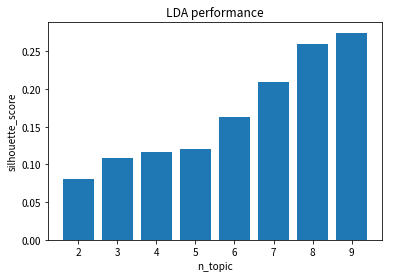

[0.081056896565026459, 0.10814795626118291, 0.11603857077173102, 0.12016134272018218, 0.16277362974295034, 0.2095452125502705, 0.26017495935137247, 0.27482109065791666]


,sentence:,topic
23,它己經 預先 安裝 數據科學家 研究人員 開發 深度神經網絡 時 軟體 包括 digits 軟體包 受歡迎 深度學習 架構 caffe theano torch nvidia 完整 gpu 加速 深度學習 庫 cudnn 2.0,0
13,digits 通往 最佳 深度神經網絡 便捷 路,0
12,現已 上市 geforce gtx titan x 售價 7999 元 人民幣,1
22,採用 四個 titan x gpu 內存 i o devbox 組件 最佳化 調試 可為 嚴苛 深度學習 研究 工作 提供 高效率 性能 表現,1
21,nvidia 深度學習 工程團隊 研發 工作 開發 digits devbox 一套 集 多項 功能 一身 平台 加快 深度學習 研究 活動,1
20,digits devbox 全球 最快 桌邊型 深度學習 機器,1
17,digits 安裝 配置 訓練 深度神經網絡 過程 中為 用戶 提供 指導 工作 科學家 專心 研究 活動,1
25,早期 gpu 訓練 成果 顯示 關鍵 深度學習 測試 中 digits devbox 提供 倍 單個 titan x 性能 digits devbox 訓練 alexnet 13 小時 gpu pc 兩天 cpu 系統 一個月 時間,1
6,geforce gtx titan x 另一面,1
5,digits devbox 全球 最快 桌邊型 深度學習 工具 專為 相關 打造 採用 titan x gpu 搭配 直觀 易用 digits 訓練 系統,1


,0,1,2,3,4
0,"(2.20330037528, 深度學習)","(7.2062144003, digits)","(7.2032498455, 訓練)","(3.20243415093, nvidia)","(2.19999466957, 領域)"
1,"(2.20288817306, 深度神經網絡)","(6.20294779597, 深度學習)","(5.20218109797, 深度神經網絡)","(3.20025890595, 深度學習)","(1.20051276987, 遊戲)"
2,"(2.20033301971, digits)","(6.19998988087, devbox)","(5.2012672164, 系統)","(2.20023373792, 技術)","(1.20023137534, 分類)"
3,"(1.20152764711, 開發)","(5.20150628244, titan)","(5.1998146968, gpu)","(2.19998981576, 推出)","(1.20018988191, 暗影)"
4,"(1.20098759372, nvidia)","(4.20272744404, 訓練)","(3.20106230406, 用戶)","(2.19998981576, 全新)","(1.20011824911, 大會)"
5,"(1.20097265204, 軟體)","(4.20157722862, gpu)","(3.19875427659, nvidia)","(1.20014026087, 即可)","(1.19999486621, 體驗)"


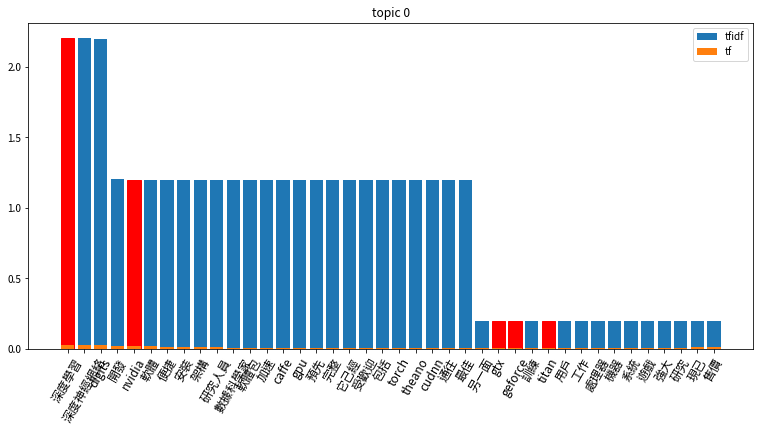

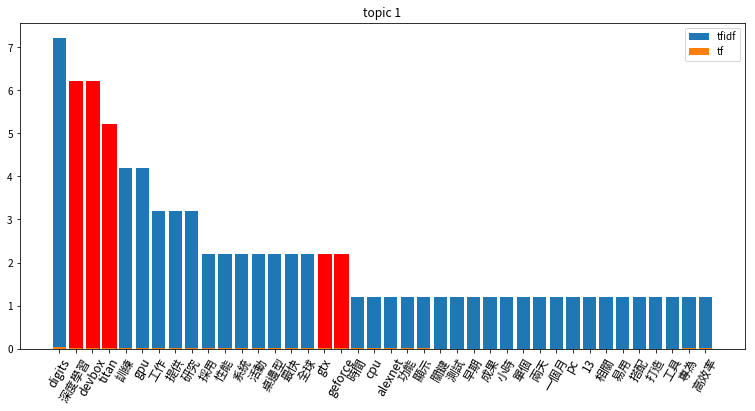

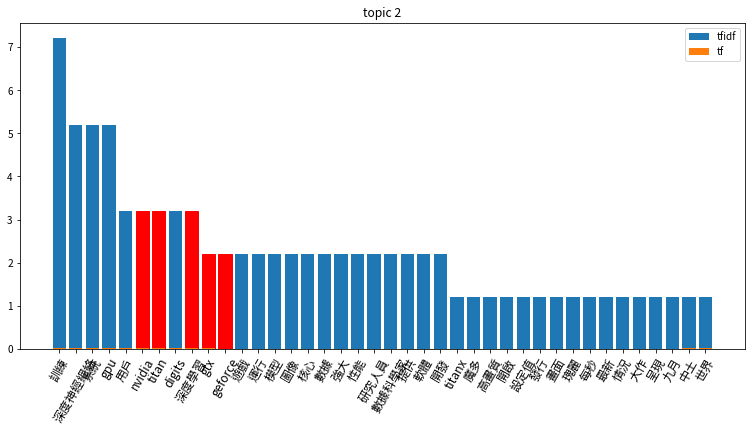

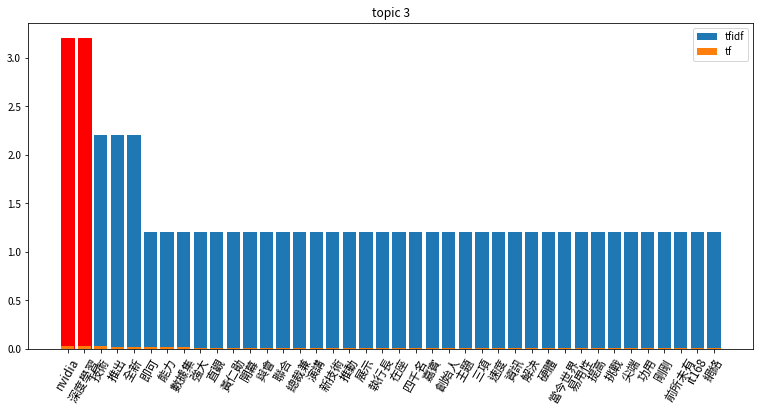

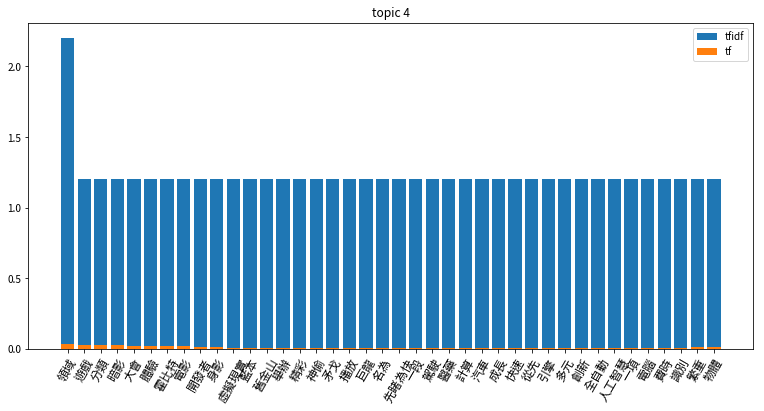

In [248]:
topic_num = 5
doc = dl_df['doc'][13]
paragraph = doc.split('\n')

paragraph_cutstrlist=[]
for p in paragraph:
    if p =='...':
        continue
    #p_cut = jieba.cut(p)
    p_cut = [_.lower() for _ in jieba.cut(p) if _ not in punct and _ not in stpwrdlst]
    p_cut_str = ' '.join(p_cut)
    paragraph_cutstrlist.append(p_cut_str)

    
cntVector = CountVectorizer()
cntTf = cntVector.fit_transform(paragraph_cutstrlist)
fea = cntVector.get_feature_names()
vec_kw =cntTf.toarray().transpose()
#vec_kw = [list(dl_w2v_model[w.lower()]) if w in dl_w2v_model else [0]*dl_w2v_model.vector_size for w in fea ]

silhouette_avgs = []
ks = range(2, 10)
for k in ks:
    lda = LatentDirichletAllocation(n_topics=k,learning_method='batch')
    docres = lda.fit_transform(cntTf)
    label = list(map(lambda x: np.argmax(x), list(zip(*lda.components_))))
    silhouette_avg = metrics.silhouette_score(np.array(vec_kw), label)
    silhouette_avgs.append(silhouette_avg)
plt.bar(ks, silhouette_avgs)
plt.title('LDA performance')
plt.ylabel('silhouette_score')
plt.xlabel('n_topic')
plt.show()
print(silhouette_avgs)


lda = LatentDirichletAllocation(n_topics=topic_num,learning_method='batch')
docres = lda.fit_transform(cntTf)
label = list(map(lambda x: np.argmax(x), list(zip(*lda.components_))))
silhouette_avg_ = metrics.silhouette_score(np.array(vec_kw), label)


topiclist = np.argmax(docres, axis=1)
doc_topic = pd.DataFrame({ 'sentence:':paragraph_cutstrlist,'topic':topiclist})
display(doc_topic.sort_values(by='topic'))


lda_kwlist= []
for i in lda.components_:
    kw, weight = sort2list(i, fea)
    lda_kwlist.append(list(zip(kw,weight)))
topic_kw = pd.DataFrame(lda_kwlist)
topic_kw = topic_kw.transpose()
display(topic_kw[:6])


for i in range(topic_num):
    kw_y, kw_x,  = zip(*topic_kw[i])
    kw_y = list(map(lambda x: float('%.3f'% x),kw_y))

    plt.figure(figsize=(13,6))
    xtmp=range(len(kw_y[:40]))
    barlist = plt.bar(xtmp, kw_y[:40], label='tfidf')
    plt.bar(xtmp, tfidf_df['tf'][:40], label='tf')
    plt.xticks(xtmp, kw_x[:40],rotation=60, fontsize=12)
    plt.legend()
    plt.title('topic {n}'.format(n=i))
    #plt.ylim(0,0.4)

    for idx, kw in enumerate(kw_x[:40]):
        if kw.upper() in keywords_predefined:
            barlist[idx].set_color('r')


***

***
***
** flask web **

def keywordmap(lyrics_df, idx, w2v_model,pca,voc_dic, kw_size=30):
    figures=[]
    all_keywords = sum(list(lyrics_df['keywords']),[])
    counter = collections.Counter(all_keywords)
    if len(set(all_keywords)) <100:
        samples = len(set(all_keywords))
    else:
        samples = 100
    topn_keywords = [w[0] for w in counter.most_common(samples)]
    this_keyword = lyrics_df['keywords'][idx]

    vec = np.array([w2v_model[w] for w in (topn_keywords+this_keyword)])

    vec_pca = pca.transform(vec)
    topn_pca = vec_pca[:samples]
    this_pca = vec_pca[samples:]

    tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=10000)
    lowdim_embs = tsne.fit_transform(vec_pca)

    topn_lowdim_embs = lowdim_embs[:samples]
    this_lowdim_embs = lowdim_embs[samples:]
    
    plt.clf()
    fig = plt.figure(figsize=(20,10))
    figures.append(fig)
    plt.subplot(121)
    plt.scatter(topn_lowdim_embs[:, 0], topn_lowdim_embs[:, 1], s= 20, label='top 100 words')
    plt.scatter(this_lowdim_embs[:, 0], this_lowdim_embs[:, 1], s= 50, label='this topic key words', color='orange')
    plt.legend()
    plt.title('PCA + T-SNE')
    for i, label in enumerate(topn_keywords):
        if label in this_keyword:
            continue
        x, y = topn_lowdim_embs[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=12,
                     ha='right',
                     va='bottom')
    for i, label in enumerate(this_keyword):
        x, y = this_lowdim_embs[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=14,
                     ha='right',
                     va='bottom',color='orange')
    
    
    plt.subplot(122)
    plt.scatter(topn_pca[:, 0], topn_pca[:, 1], s= 20, label='top 100 words')
    plt.scatter(this_pca[:, 0], this_pca[:, 1], s= 50, label='this topic key words', color='orange')
    plt.legend()
    plt.title('PCA')
    for i, label in enumerate(topn_keywords):
        if label in this_keyword:
            continue
        x, y = topn_pca[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=12,
                     ha='right',
                     va='bottom')
    for i, label in enumerate(this_keyword):
        x, y = this_pca[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=14,
                     ha='right',
                     va='bottom',color='orange')


    fig2 = plt.figure(figsize=(15,6))
    figures.append(fig2)
    tfidf_vec = lyrics_df['tfidf_vector'][idx]
    topn_vec , topn_word= sort2list(list(tfidf_vec) , list(voc_dic.values()))
    plt.bar(range(len(topn_vec[:kw_size])), topn_vec[:kw_size])
    plt.xticks(range(len(topn_vec[:kw_size])), topn_word[:kw_size],rotation=60, fontsize=12)
    plt.title('tfidf keywords')
    #print(topn_word[:n])
    #plt.show()
    
    for kw in lyrics_df['keywords'][idx]:
        fig3 = plt.figure(figsize=(15,6))
        figures.append(fig3)
        similarwords = w2v_model.most_similar(kw, topn=kw_size)
        words, similarity = zip(*similarwords)
        barlist = plt.bar(range(len(similarity)), similarity)
        plt.xticks(range(len(similarity)), words,rotation=60, fontsize=12)
        plt.title('similar word of {kw}'.format(kw=kw))
        #barlist[0].set_color('r')
        #print(words)
        #plt.show()
    return figures

urls = [
    ['', '', '/', '']
    , ['deeplearningSummary', 'docid,topic', '/deeplearningSummary/0/4', 'test']
]
df_url = pd.DataFrame(urls, columns=['page', 'ps', 'instance', 'remark']).set_index('page')
df_url['instance'] = df_url['instance'].map(lambda x: '<a href="%s">%s</a>'%(x, x) if x != '' else '')


app = Flask(__name__)

def get_ps(page, path):
    names = df_url.ix[page]['ps'].split(',')
    try:
        ps = {k: v for k, v in zip(names, path.split('/'))}
    except:
        ps = {}
    return ps

def get_route(df_url, page):
    return '/%s'%page + ''.join(['/<%s>'%_ for _ in df_url.ix[page]['ps'].split(',') if len(_)>0 ])

@app.route('/')
def root(**ps):    
    cards = [['URL', [['table', df_url.reset_index()[['page', 'instance', 'ps', 'remark']]]] ]]
    try:
        texts = ['hi, %s'%flask_login.current_user.id]
    except:
        texts = []
    return ht.HtmlTemplate('Root', cards=cards, texts=texts).to_html()


topic_list=[w for w in os.listdir('text_dl') if not w.startswith('.')]
topic=-1
dl_df=None
dl_w2v_model=None
dl_pca=None
dl_voc_dic=None
@app.route('/deeplearningSummary/<path:path>')
def deeplearningSummary(path=''):
    global topic
    global dl_df
    global dl_w2v_model
    global dl_pca
    global dl_voc_dic
    #print(path)
    ps={}
    ps = get_ps('deeplearningSummary', path)
    #print(ps)
    docid = int(ps.get('docid'))  #docid
    topic_new = int(ps.get('topic'))  #topic
    print(topic_new)
    topic_str = topic_list[topic_new]
    
    if topic!=topic_new:
        dl_df, dl_voc_dic, dl_w2v_model, dl_pca = read01_summary(folder = 'text/techdoc', topic=topic_str, kw_topn=50)
        tipic=topic_new
    
    selected_doc = dl_df.ix[docid]
    
    cards = []
    content=[]
    
    display_detailcols=['fname', 'doc', 'keywords', 'summary']
    for col in display_detailcols:
        content.append(['text', '<font color="blue">{col}</font>'.format(col=col)])
        content.append(['text',selected_doc[col]])
    
    similarwords=OrderedDict()
    for kw in list(dl_df['keywords'][0]):
        similarword=dl_w2v_model.most_similar(kw,topn=20)
        similarwords[kw]=similarword
    similarwords_df = pd.DataFrame(similarwords)
    content.append(['text', '<font color="blue">{col}</font>'.format(col='similar words')])
    content.append(['table',similarwords_df])
    
    content.append(['text', '<font color="blue"> Text Summary</font>'])
    content.append(['table', dl_df[['fname','keywords','summary']]])
    
    cards.append(['text summary', content ])
    
    figs = keywordmap(dl_df, docid, dl_w2v_model, dl_pca,dl_voc_dic, kw_size=50)
    
    content=[]
    for f in figs:
        content.append(['fig', f])
    cards.append(['keyword map', content ])

    
    controls = []
    controls.append( ht.Control_Select(id='docid', text='doc', options=list(range(dl_df.shape[0])), value=docid, labels=list((dl_df['fname'])) ))
    controls.append( ht.Control_Select(id='topic', text='topic', options=list(range(len(topic_list))), value=topic_new, labels=topic_list ))
    
    return ht.HtmlTemplate('Text Summary App', ps, cards, controls=controls, page='deeplearningSummary').to_html()


if __name__ == '__main__':
    app.run(host='0.0.0.0',port=5001)


***
** 下面都沒用 **

In [73]:
raw_documents = [  
    '无偿居间介绍买卖毒品的行为应如何定性',  
    '吸毒男动态持有大量毒品的行为该如何认定',  
    '如何区分是非法种植毒品原植物罪还是非法制造毒品罪',  
    '为毒贩贩卖毒品提供帮助构成贩卖毒品罪',  
    '将自己吸食的毒品原价转让给朋友吸食的行为该如何认定',  
    '为获报酬帮人购买毒品的行为该如何认定',  
    '毒贩出狱后再次够买毒品途中被抓的行为认定',  
    '虚夸毒品功效劝人吸食毒品的行为该如何认定',  
    '妻子下落不明丈夫又与他人登记结婚是否为无效婚姻',  
    '一方未签字办理的结婚登记是否有效',  
    '夫妻双方1990年按农村习俗举办婚礼没有结婚证 一方可否起诉离婚',  
    '结婚前对方父母出资购买的住房写我们二人的名字有效吗',  
    '身份证被别人冒用无法登记结婚怎么办？',  
    '同居后又与他人登记结婚是否构成重婚罪',  
    '未办登记只举办结婚仪式可起诉离婚吗',  
    '同居多年未办理结婚登记，是否可以向法院起诉要求离婚'  
]  
corpora_documents = list(map(lambda x: [_.lower() for _ in jieba.cut(x) if _ not in punct and _ not in stpwrdlst], raw_documents))
dictionary = gensim.corpora.Dictionary(corpora_documents)  
dictionary_ = dictionary.token2id
corpus = [dictionary.doc2bow(text) for text in corpora_documents]  

tfidf = gensim.models.TfidfModel(corpus)  
corpus_tfidf = tfidf[corpus]  


In [82]:
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(5, 1), (6, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)],
 [(5, 2),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 2),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 2)],
 [(21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1)],
 [(5, 1),
  (6, 1),
  (10, 1),
  (13, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 2),
  (33, 1)],
 [(5, 1),
  (6, 1),
  (10, 1),
  (13, 1),
  (27, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1)],
 [(5, 1),
  (6, 1),
  (10, 1),
  (22, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1)],
 [(5, 1), (6, 1), (10, 1), (13, 1), (43, 1), (44, 1), (45, 1), (46, 1)],
 [(27, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1)],
 [(55, 1), (56, 1), (57, 1), (58, 1), (59, 1)],
 [(58, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1)],
 [(35, 1),
  (48

In [296]:
model = gensim.models.Word2Vec(corpora_documents,size=1000)  
print(model.most_similar('毒品',topn=10))  


[('认定', 0.009709158912301064), ('行为', 0.002374814823269844)]


In [323]:

#根据结果使用lsi做主题分类效果会比较好  
print('#############'*4)  
lsi = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=dictionary, num_topics=2)  
corpus_lsi = lsi[corpus_tfidf]  
lsi.print_topics(2)  
for doc in corpus_lsi:  
    print(doc)  
  
print('#############'*4)  
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=2, update_every=0, passes=1)  
corpus_lda = lda[corpus_tfidf]  
lda.print_topics(2)  
for doc in corpus_lda:  
    print(doc)  


####################################################
[(0, -0.23410103077983349), (1, 0.011843267555030668)]
[(0, -0.41225681614344245), (1, 0.01049553922617532)]
[(0, -0.41800771429351924), (1, 0.051072313185953032)]
[(0, -0.13556127419840086), (1, -0.06427069602101787)]
[(0, -0.44923853996864671), (1, 0.017511845929118041)]
[(0, -0.4443137198257352), (1, -0.050711244013925717)]
[(0, -0.35144142301030978), (1, -0.024096206962838037)]
[(0, -0.41225681614344256), (1, 0.010495539226175441)]
[(0, -0.04476549245259194), (1, -0.24701133935966091)]
[(0, -0.00029136258278697388), (1, -0.14489520153349048)]
[(0, -0.0016280184342399283), (1, -0.77903240061368451)]
[(0, -0.037814610810071023), (1, -0.24205402445064206)]
[(0, -0.0097524469098568666), (1, -0.17843531001894597)]
[(0, -0.052485444130123515), (1, -0.27613725725807547)]
[(0, -0.0080526447256474409), (1, -0.52806064637552097)]
[(0, -0.0033811039504574904), (1, -0.359041638171405)]
####################################################
[(0